# Trabajo Práctico - Seminario intensivo - Priolo, Juan 

### En la siguiente notebook, se ha levantado del ambiente (docker compose) un dataset extraido de Kaggle. El dataset contiene propieades que se obtienen del acero, partiendo de diferentes elementos químicos y realizándole distintos tratamientos térmicos.

### En una primera instancia se hará un análisis exploratorio del dataset, luego se transformarán algunos de sus componentes y luego 70% del dataset será utilizado para entrenar un modelo de aprendizaje automático y el restante 30% para hacer el testeo de ese modelo

########## pySpark Commands Reference
https://spark.apache.org/docs/2.4.4/api/python/index.html


########## Connect to Spark Cluster
https://github.com/minrk/findspark

In [712]:
import findspark
findspark.init()

In [713]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-df-overview")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

In [714]:
spark.version

'2.4.5'

In [715]:
mechanical_dir = '/dataset/Mechanical_properties_of_lowalloy_steels'

### Create Spark DataFrame
Dataset from: https://www.kaggle.com/rohannemade/mechanical-properties-of-low-alloy-steels

In [716]:
df = spark.read.csv("/dataset/Mechanical_properties_of_lowalloy_steels.csv", header=True)

In [717]:
import sys

from pyspark.sql import SparkSession

# UDF
from pyspark.sql.types import StringType
#
from pyspark.sql import functions as F
from pyspark.sql.window import Window

### Análisis exploratorio del dataset

In [719]:
df.count()

915

In [720]:
df.printSchema()

root
 |-- Alloy code: string (nullable = true)
 |--  C: string (nullable = true)
 |--  Si: string (nullable = true)
 |--  Mn: string (nullable = true)
 |--  P: string (nullable = true)
 |--  S: string (nullable = true)
 |--  Ni: string (nullable = true)
 |--  Cr: string (nullable = true)
 |--  Mo: string (nullable = true)
 |--  Cu: string (nullable = true)
 |-- V: string (nullable = true)
 |--  Al: string (nullable = true)
 |--  N: string (nullable = true)
 |-- Ceq: string (nullable = true)
 |-- Nb + Ta: string (nullable = true)
 |--  Temperature (°C): string (nullable = true)
 |--  0.2% Proof Stress (MPa): string (nullable = true)
 |--  Tensile Strength (MPa): string (nullable = true)
 |--  Elongation (%): string (nullable = true)
 |--  Reduction in Area (%): string (nullable = true)



In [721]:
df.show(5)

+----------+----+----+----+-----+-----+-----+----+----+----+---+-----+------+---+-------+-----------------+------------------------+-----------------------+---------------+----------------------+
|Alloy code|   C|  Si|  Mn|    P|    S|   Ni|  Cr|  Mo|  Cu|  V|   Al|     N|Ceq|Nb + Ta| Temperature (°C)| 0.2% Proof Stress (MPa)| Tensile Strength (MPa)| Elongation (%)| Reduction in Area (%)|
+----------+----+----+----+-----+-----+-----+----+----+----+---+-----+------+---+-------+-----------------+------------------------+-----------------------+---------------+----------------------+
|       MBB|0.12|0.36|0.52|0.009|0.003|0.089|0.97|0.61|0.04|  0|0.003|0.0066|  0|      0|               27|                     342|                    490|             30|                    71|
|       MBB|0.12|0.36|0.52|0.009|0.003|0.089|0.97|0.61|0.04|  0|0.003|0.0066|  0|      0|              100|                     338|                    454|             27|                    72|
|       MBB|0.12|0.3

In [722]:
from pyspark.sql.types import DoubleType, IntegerType

In [723]:
df = df.withColumn(' C', df[' C'].cast(DoubleType()))
df = df.withColumn(' Si', df[' Si'].cast(DoubleType()))
df = df.withColumn(' Mn', df[' Mn'].cast(DoubleType()))
df = df.withColumn(' P', df[' P'].cast(DoubleType()))
df = df.withColumn(' S', df[' S'].cast(DoubleType()))
df = df.withColumn(' Ni', df[' Ni'].cast(DoubleType()))
df = df.withColumn(' Cr', df[' Cr'].cast(DoubleType()))
df = df.withColumn(' Mo', df[' Mo'].cast(DoubleType()))
df = df.withColumn(' Cu', df[' Cu'].cast(DoubleType()))
df = df.withColumn(' Al', df[' Al'].cast(DoubleType()))
df = df.withColumn('V', df['V'].cast(DoubleType()))
df = df.withColumn(' N', df[' N'].cast(DoubleType()))
df = df.withColumn(' Al', df[' Al'].cast(DoubleType()))
df = df.withColumn('Ceq', df['Ceq'].cast(DoubleType()))
df = df.withColumn('Nb + Ta', df['Nb + Ta'].cast(DoubleType()))
df = df.withColumn(' Temperature (°C)', df[' Temperature (°C)'].cast(DoubleType()))
df = df.withColumn(' Tensile Strength (MPa)', df[' Tensile Strength (MPa)'].cast(DoubleType()))
df = df.withColumn(' Elongation (%)', df[' Elongation (%)'].cast(DoubleType()))
df = df.withColumn(' Reduction in Area (%)', df[' Reduction in Area (%)'].cast(DoubleType()))

In [724]:
df.printSchema()

root
 |-- Alloy code: string (nullable = true)
 |--  C: double (nullable = true)
 |--  Si: double (nullable = true)
 |--  Mn: double (nullable = true)
 |--  P: double (nullable = true)
 |--  S: double (nullable = true)
 |--  Ni: double (nullable = true)
 |--  Cr: double (nullable = true)
 |--  Mo: double (nullable = true)
 |--  Cu: double (nullable = true)
 |-- V: double (nullable = true)
 |--  Al: double (nullable = true)
 |--  N: double (nullable = true)
 |-- Ceq: double (nullable = true)
 |-- Nb + Ta: double (nullable = true)
 |--  Temperature (°C): double (nullable = true)
 |--  0.2% Proof Stress (MPa): string (nullable = true)
 |--  Tensile Strength (MPa): double (nullable = true)
 |--  Elongation (%): double (nullable = true)
 |--  Reduction in Area (%): double (nullable = true)



###### Remuevo 'Alloy code'  y '0.2% Proof  Stress (Mpa)' ya que no aporta valor

In [725]:
df = df.drop('Alloy code', ' 0.2% Proof Stress (Mpa)', ' Reduction in Area (%)','Nb + Ta')
df.printSchema()

root
 |--  C: double (nullable = true)
 |--  Si: double (nullable = true)
 |--  Mn: double (nullable = true)
 |--  P: double (nullable = true)
 |--  S: double (nullable = true)
 |--  Ni: double (nullable = true)
 |--  Cr: double (nullable = true)
 |--  Mo: double (nullable = true)
 |--  Cu: double (nullable = true)
 |-- V: double (nullable = true)
 |--  Al: double (nullable = true)
 |--  N: double (nullable = true)
 |-- Ceq: double (nullable = true)
 |--  Temperature (°C): double (nullable = true)
 |--  Tensile Strength (MPa): double (nullable = true)
 |--  Elongation (%): double (nullable = true)



### Corrijo los títulos (borro un espacio inicial que tenían del dataset & simplifico algunos wordings)

In [726]:
df = df.withColumnRenamed(" C", "C")
df = df.withColumnRenamed(" Si", "Si") 
df = df.withColumnRenamed(" Mn", "Mn") 
df = df.withColumnRenamed(" P", "P")
df = df.withColumnRenamed(" S", "S") 
df = df.withColumnRenamed(" Ni", "Ni") 
df = df.withColumnRenamed(" Cr", "Cr") 
df = df.withColumnRenamed(" Mo", "Mo") 
df = df.withColumnRenamed(" Cu", "Cu") 
df = df.withColumnRenamed(" Al", "Al") 
df = df.withColumnRenamed(" N", "N") 
df = df.withColumnRenamed(" Temperature (°C)", "Temperature") 
df = df.withColumnRenamed(" Tensile Strength (Mpa)", "UTS") 
df = df.withColumnRenamed(" Elongation (%)", "Elong") 

In [727]:
df.printSchema()

root
 |-- C: double (nullable = true)
 |-- Si: double (nullable = true)
 |-- Mn: double (nullable = true)
 |-- P: double (nullable = true)
 |-- S: double (nullable = true)
 |-- Ni: double (nullable = true)
 |-- Cr: double (nullable = true)
 |-- Mo: double (nullable = true)
 |-- Cu: double (nullable = true)
 |-- V: double (nullable = true)
 |-- Al: double (nullable = true)
 |-- N: double (nullable = true)
 |-- Ceq: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- UTS: double (nullable = true)
 |-- Elong: double (nullable = true)



### Creating charts with pandas & matplotlib
https://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-plotting

**Important:** possible only when data become small enough to driver program

In [728]:
import seaborn as sns

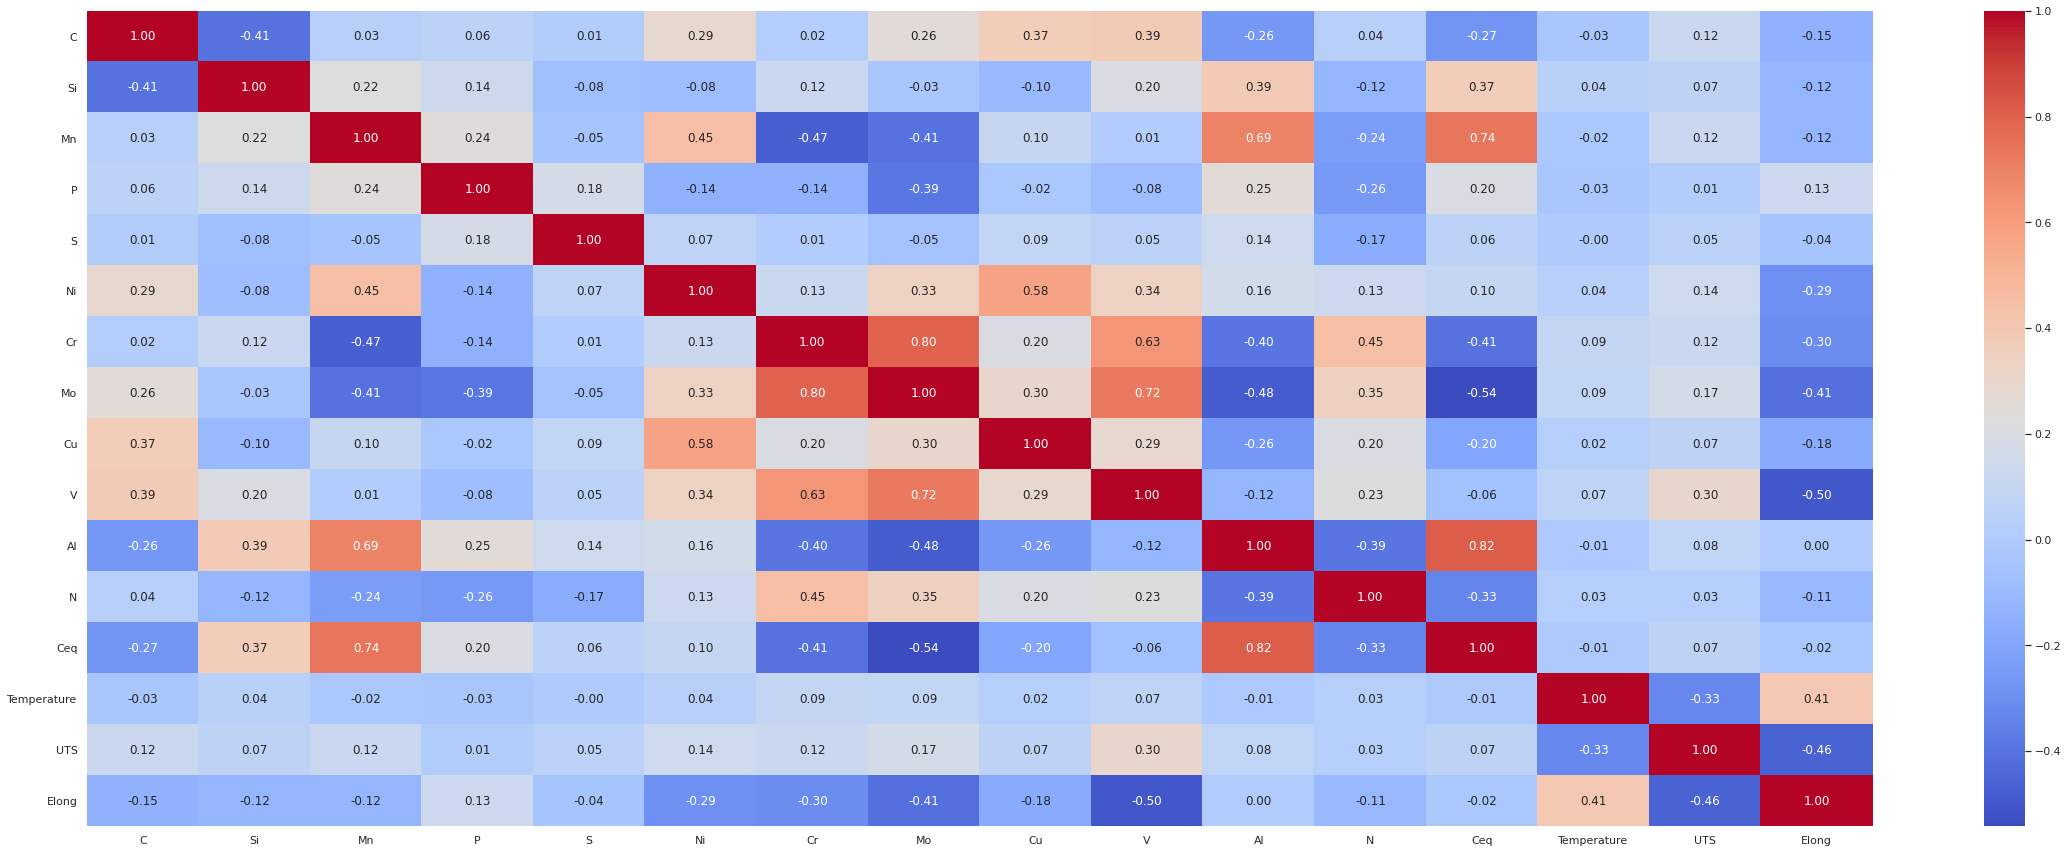

In [729]:
g = sns.heatmap(df.select('C','Si','Mn','P','S','Ni','Cr','Mo','Cu','V','Al','N','Ceq',
                          'Temperature','UTS','Elong').toPandas().corr(),
                annot= True , fmt = ".2f", cmap = "coolwarm")
sns.set(rc = {'figure.figsize':(40,15)})

## Del gráfico anterior destaco:
#### Entre elementos:
#####  A mayor carbono, menor el silicio y el aluminio que se agrega. Asociado a una explicación metalúrgica pero se ve en los diseños de las químicas utilizadas en este caso.
#####  Se ven correlaciones fuertes entre el Aluminio y el Manganesio, entre el Vanadio y el Cromo o el Molybdeno, entre el Molybdeno y el Cromo. En todos los casos anteriores correlaciones positivas > a 0.6.

#### Entre elementos y el Ceq (carbono equivalente)
##### Existe una correlación fuerte entre el Mn y el Ceq (carbono equivalente). 

#### Entre % de alargamiento (Elongation) y la temperatura de tratamiento térmico
###### % Elongation aumenta con el aumento de la temperatura. A mayores temperaturas de remanencia de un material en un horno, este tiende a "ablandarse" por lo cual presenta mayor "estiramiento" u elongación. 

#### UTS (Mpa) o resistencia última del material vs la temperatura de tratamiento térmico
##### Tensile Strength (resistencia del material) cae con el aumento de la temperatura. A mayores temperaturas de remanencia de un acero en un horno, la resistencia del material tiende a caer. 

#### %C vs Temperatura y % of Elongation
##### Se ve un aumento de la Resistencia del material al incrementar el % de C y el % Mn. 
##### Se ve una caida de la del estiramiento del material al incrementar el % de C y el % Mn. 
##### A mayor % C o mayor %Mn se ve que el material tiene un compartamiento con mayor resistencia, más fragil y a su vez con menor capacidad de elongación. 

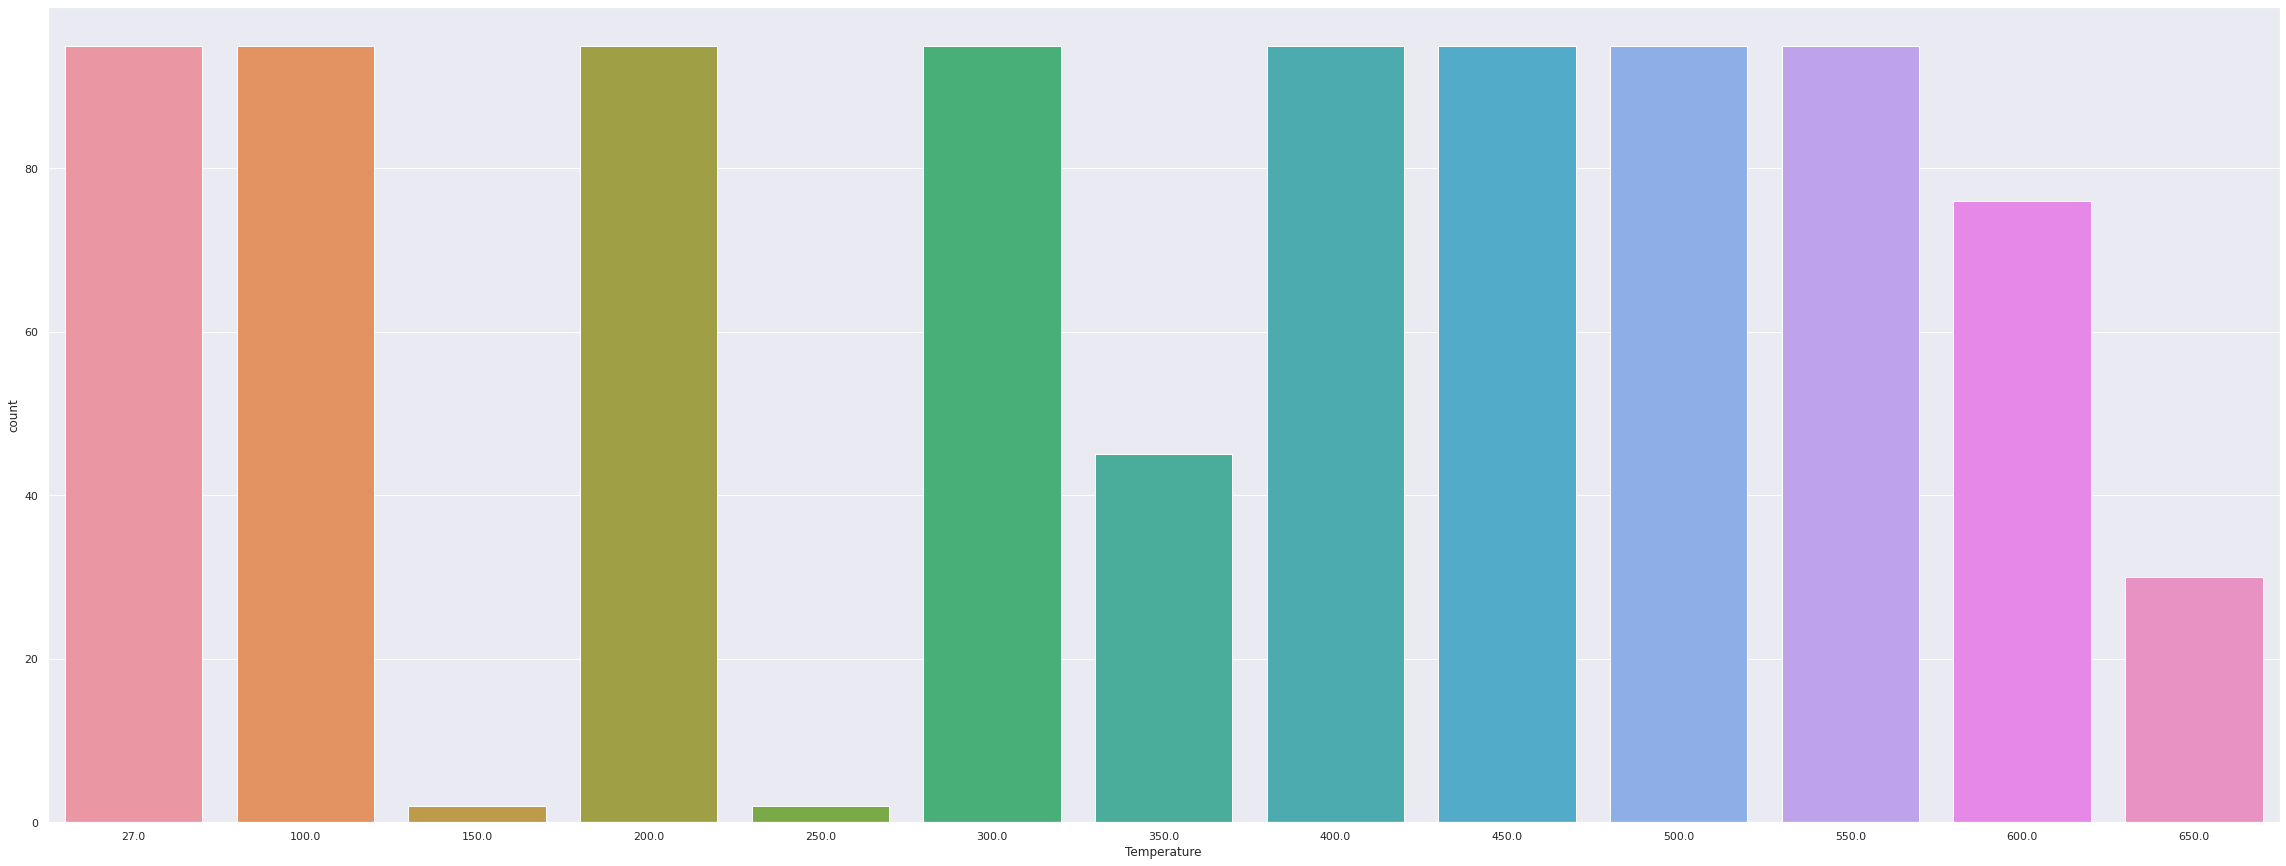

In [730]:
g = sns.countplot(df.select('Temperature').toPandas().squeeze())

## Del gráfico anterior destaco:
#### Vemos que los tratamientos térmicos aplicados van en un rango de tempartura de Temperatura ambiente hasta los 650°C. Según la teoría, se aplican a drede para obtener distintas propiedades mecánicas.

In [731]:
df.select('Temperature').groupBy('Temperature').count().show()

+-----------+-----+
|Temperature|count|
+-----------+-----+
|       27.0|   95|
|      100.0|   95|
|      200.0|   95|
|      450.0|   95|
|      600.0|   76|
|      350.0|   45|
|      150.0|    2|
|      300.0|   95|
|      400.0|   95|
|      500.0|   95|
|      550.0|   95|
|      650.0|   30|
|      250.0|    2|
+-----------+-----+



## Lo guardo en formato Parquet

In [732]:
output_dir = '/dataset/output.parquet'

In [733]:
df \
    .write \
    .mode('overwrite') \
    .parquet(output_dir)

In [734]:
df_parquet = spark.read.parquet(output_dir)

In [735]:
df_parquet.count()

915

In [736]:
df_parquet.createOrReplaceTempView("mechanical_properties4")

## Hago la segmentación training - Test que voy a usar más adelante. Lo agrego al dataset

In [737]:
train_df, test_df = df.randomSplit([0.7,0.3],seed=1234)

In [738]:
train_df.count()

665

In [739]:
from pyspark.sql.functions import rand, when
df = df.withColumn('train', when(rand(seed=1234) > 0.3, True).otherwise(False))

In [740]:
df.select('train').groupby('train').count().show()

+-----+-----+
|train|count|
+-----+-----+
| true|  622|
|false|  293|
+-----+-----+



In [741]:
df.select('train').printSchema()

root
 |-- train: boolean (nullable = false)



In [742]:
import pyspark.sql.functions as f

In [743]:
df_train = df.filter(f.col('train') == True)

In [744]:
df_train.count()

622

In [745]:
df_test = df.filter(f.col('train') != True)

In [746]:
df_test.count()

293

## Machine Learning

###### Todos los atributos de mi dataset son numéricos por lo cual no voy a necesitar hacer el pasaje de categórico a numérico.

In [749]:
type(df)

pyspark.sql.dataframe.DataFrame

In [750]:
df.printSchema()

root
 |-- C: double (nullable = true)
 |-- Si: double (nullable = true)
 |-- Mn: double (nullable = true)
 |-- P: double (nullable = true)
 |-- S: double (nullable = true)
 |-- Ni: double (nullable = true)
 |-- Cr: double (nullable = true)
 |-- Mo: double (nullable = true)
 |-- Cu: double (nullable = true)
 |-- V: double (nullable = true)
 |-- Al: double (nullable = true)
 |-- N: double (nullable = true)
 |-- Ceq: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- UTS: double (nullable = true)
 |-- Elong: double (nullable = true)
 |-- train: boolean (nullable = false)



###### Todos los atributos de mi dataset son numéricos por lo cual no voy a necesitar hacer el pasaje de categórico a numérico.
###### Sin embargo, dejo

In [751]:
from pyspark.ml.feature import StringIndexer

def _encode_categorical(df):
    cat_cols = _get_typed_cols(df, col_type='cat')
    logger.info(f"Categorical columns:\n {cat_cols}")
    encoded_cols = []
    for cat in cat_cols:
        cat_suff = f'{cat}_num'
        encoded_cols.append(cat_suff)
        if cat_suff not in df.columns:
            indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(df)
            df = indexer.transform(df)
    return df, encoded_cols

#### El modelo queda a modo de ejemplo, para trabajar sobre un ejemplo más pequeño y sobre un caso que tiene variables categóricas (no sería el caso del dataset sobre las propiedades del acero).

In [752]:
# Data sintetica
df1 = spark.createDataFrame([
    (1, 10.1, 'a', 'i'),
    (0, 14.3, 'b', 'x'),
    (0, 3.0, 'c', 'iv'),
    (1, 2.5, 'c', 'iv'),
    (1, 5.4, 'b', 'i'),
    (0, 9.7, 'a', 'x')
], ['target', 'numerical', 'cat1', 'cat2'])
df1.show()

# Convertir strings en numericos
from pyspark.ml.feature import StringIndexer

cat_cols = ['cat1', 'cat2']
for cat in cat_cols:
    cat_suff = f'{cat}_num'
    if cat_suff not in df1.columns:
        indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(df1)
        df1 = indexer.transform(df1)
df1.show()

# Hacer OneHotEnconding
from pyspark.ml.feature import OneHotEncoderEstimator

encoder = OneHotEncoderEstimator(inputCols=['cat1_num', 'cat2_num'], outputCols=['cat1_vec', 'cat2_vec'])
ohem = encoder.fit(df1)
df1 = ohem.transform(df1)
df1.show()

# Armar columna de features
df1 = df1.select('target','numerical', 'cat1_vec', 'cat2_vec')
df1.show()
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[c for c in df1.columns if c != 'target'], outputCol='features')
assembler.transform(df1).show()

+------+---------+----+----+
|target|numerical|cat1|cat2|
+------+---------+----+----+
|     1|     10.1|   a|   i|
|     0|     14.3|   b|   x|
|     0|      3.0|   c|  iv|
|     1|      2.5|   c|  iv|
|     1|      5.4|   b|   i|
|     0|      9.7|   a|   x|
+------+---------+----+----+

+------+---------+----+----+--------+--------+
|target|numerical|cat1|cat2|cat1_num|cat2_num|
+------+---------+----+----+--------+--------+
|     1|     10.1|   a|   i|     1.0|     1.0|
|     0|     14.3|   b|   x|     0.0|     0.0|
|     0|      3.0|   c|  iv|     2.0|     2.0|
|     1|      2.5|   c|  iv|     2.0|     2.0|
|     1|      5.4|   b|   i|     0.0|     1.0|
|     0|      9.7|   a|   x|     1.0|     0.0|
+------+---------+----+----+--------+--------+

+------+---------+----+----+--------+--------+-------------+-------------+
|target|numerical|cat1|cat2|cat1_num|cat2_num|     cat1_vec|     cat2_vec|
+------+---------+----+----+--------+--------+-------------+-------------+
|     1|     

### Llevo los features a un vector y el target (UTS) separado. 

In [754]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=[c for c in df.columns if c != 'UTS'], outputCol='features')
df = assembler.transform(df)
df.select('features').show()

IllegalArgumentException: 'Output column features already exists.'

In [755]:
df.columns

['C',
 'Si',
 'Mn',
 'P',
 'S',
 'Ni',
 'Cr',
 'Mo',
 'Cu',
 'V',
 'Al',
 'N',
 'Ceq',
 'Temperature',
 'UTS',
 'Elong',
 'train',
 'features']

In [756]:
df.select('train').take(2)

[Row(train=True), Row(train=True)]

In [757]:
train_data = df.filter(f.col('train') == True).select('UTS', 'features')
test_data = df.filter(f.col('train') == False).select('UTS', 'features')
train_data.show()

+-----+--------------------+
|  UTS|            features|
+-----+--------------------+
|490.0|[0.12,0.36,0.52,0...|
|454.0|[0.12,0.36,0.52,0...|
|465.0|[0.12,0.36,0.52,0...|
|495.0|[0.12,0.36,0.52,0...|
|489.0|[0.12,0.36,0.52,0...|
|461.0|[0.12,0.36,0.52,0...|
|387.0|[0.12,0.36,0.52,0...|
|314.0|[0.12,0.36,0.52,0...|
|226.0|[0.12,0.36,0.52,0...|
|463.0|[0.09,0.37,0.49,0...|
|439.0|[0.09,0.37,0.49,0...|
|471.0|[0.09,0.37,0.49,0...|
|367.0|[0.09,0.37,0.49,0...|
|463.0|[0.1,0.28,0.49,0....|
|459.0|[0.1,0.28,0.49,0....|
|473.0|[0.1,0.28,0.49,0....|
|451.0|[0.1,0.28,0.49,0....|
|424.0|[0.1,0.28,0.49,0....|
|378.0|[0.1,0.28,0.49,0....|
|502.0|[0.12,0.43,0.48,0...|
+-----+--------------------+
only showing top 20 rows



In [758]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='UTS', featuresCol='features')
lrm = lr.fit(train_data)

In [759]:
dir(lrm.summary)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_call_java',
 '_create_from_java_class',
 '_java_obj',
 '_new_java_array',
 '_new_java_obj',
 'accuracy',
 'fMeasureByLabel',
 'falsePositiveRateByLabel',
 'featuresCol',
 'labelCol',
 'labels',
 'objectiveHistory',
 'precisionByLabel',
 'predictionCol',
 'predictions',
 'probabilityCol',
 'recallByLabel',
 'totalIterations',
 'truePositiveRateByLabel',
 'weightedFMeasure',
 'weightedFalsePositiveRate',
 'weightedPrecision',
 'weightedRecall',
 'weightedTruePositiveRate']

In [764]:
# Metricas de evaluacion (insample)
lrm.summary.accuracy

0.684887459807074

In [765]:
pred_df = lrm.transform(test_data)
pred_df.show(40)

+-----+--------------------+--------------------+--------------------+----------+
|  UTS|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|431.0|[0.12,0.36,0.52,0...|[-8.8860847322831...|[1.80309204743911...|     461.0|
|427.0|[0.09,0.37,0.49,0...|[-8.5909343012708...|[6.75976885872915...|     463.0|
|472.0|[0.09,0.37,0.49,0...|[-8.8861447369102...|[7.67580832815819...|     367.0|
|451.0|[0.09,0.37,0.49,0...|[-8.8583402227365...|[2.41814365321129...|     367.0|
|423.0|[0.09,0.37,0.49,0...|[-9.0358857177547...|[5.05106272978149...|     367.0|
|297.0|[0.09,0.37,0.49,0...|[-10.007026735367...|[2.20669550906189...|     367.0|
|205.0|[0.09,0.37,0.49,0...|[-11.262659778643...|[2.38489238535312...|     226.0|
|432.0|[0.1,0.28,0.49,0....|[-8.6113719229212...|[2.11232352637447...|     459.0|
|464.0|[0.1,0.28,0.49,0....|[-9.0092573631566...|[7.05024745480281...|     473.0|
|297.0|[0.1,0.28

In [766]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='UTS')
evaluator.evaluate(pred_df)

1.0

In [767]:
evaluator?

In [701]:
## Claramente no es la métrica a utilizar en este caso. 

#### Para el TP final voy a aplicar mismo concepto, con Árboles y Random Forest, utilizando otras métricas para comparar modelos. El dataset a utilizar tiene un formato similar. 

# Continue Learning

* [Kaggle Learn](https://www.kaggle.com/learn/overview)
* [PySpark Cookbook](https://www.safaribooksonline.com/library/view/pyspark-cookbook/9781788835367/)

## Other references

* [PySpark Tutorial for Beginners: Machine Learning Example](https://www.guru99.com/pyspark-tutorial.html)